Your company owns a chain of stores across Russia that sell a variety of alcoholic drinks. The company recently ran a wine promotion in Saint Petersburg that was very successful. <br>
Due to the cost to the business, it isn’t possible to run the promotion in all regions. <br>
The marketing team would like to target 10 other regions that have similar buying habits to Saint Petersburg where they would expect the promotion to be similarly successful.

# Content
1. The Dataset
2. Analysis Plan
3. Exploratory Data Analysis
4. Feature Selection and Engineering
5. Clustering Implementation
6. Final Recommendation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

# Dataset
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

<b>Data Dictionary</b>: <br>
* "year" - year (1998-2016) <br>
* "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast <br>
* "wine" - sale of wine in litres by year per capita <br>
* "beer" - sale of beer in litres by year per capita <br>
* "vodka" - sale of vodka in litres by year per capita <br>
* "champagne" - sale of champagne in litres by year per capita <br>
* "brandy" - sale of brandy in litres by year per capita <br>

In [20]:
filterwarnings("ignore")

# Setting Seed Value
seed = 42

sns.set_context('talk')

In [3]:
master = pd.read_csv("russian_alcohol_consumption.csv")
master.head()

,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


### Handling missing values: <br>

Missing values identification

In [5]:
segments = ['wine', 'beer', 'vodka', 'champagne', 'brandy']
segments_shr = [s + '_shr' for s in segments]

In [8]:
nan_count = master[master[segments].isnull().any(axis=1)]
nan_count['na_count'] = nan_count[segments].isnull().sum(axis=1)
nan_pivot = nan_count.pivot_table(index='region', columns='year', values='na_count', aggfunc='sum').fillna(0)
nan_pivot

year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0
Republic of Crimea,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0
Republic of Ingushetia,5.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0
Sevastopol,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0


Based on the counts above, it would make sense to completely drop regions with most of the data missing <br>
- Chechen Republic
- Republic of Crimea
- Republic of Ingushetia
- Sevastopol

In [11]:
# Drop regions with mostly missing data
print(master.shape)
master = master[~master.region.isin(nan_pivot.index.to_list())]
master.head()

(1539, 7)


,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


---

This project is about identifying patterns in unlabeled dataset which makes it <b>unsupervised</b> machine learning.Thus <b>clustering</b> appears to be the most reasonable choice of the model.<br> Since the size of the dataset is relatively small and we only really care about identifying regions similar to Saint Patersburg, <b>hierarchical clustering</b> appears to be the method of choice. Once we complete clustering, we will need to rank the regions from the same cluster as Saint Petersburg to select top 10.<br> To be able to do to the ranking successfully, we need to have a good understanding of what makes Saint Petersburg different from other regions. This will allow us to to prioritize the regions in the optimal way.

Steps:
1. Exploratory Data Analyis (EDA) to visualize average trends across all regions and trends in Saint Petersburg region to highlight the difference
2. Selecting and engineering the clustering variables (features) based on the resutls of EDA
3. Implementing clustering and tuning the parameters to get to a tight group of regions
4. Exploring reduction of the features (variables) to eliminate noise using Principal Component Analysis (PCA)
5. Ranking the regions from the same cluster as Saint Petersburg for the final recommendations

In [13]:
# Total Alcohol Consumption
master["total_alc"] = master.apply(lambda x: x.wine + x.beer + x.vodka + x.champagne + x.brandy,axis=1)

# Adding consumption as the share of total:

for s in segments:
    master[s+'_shr'] = master.apply(lambda x: x[s] / x["total_alc"],axis=1)

# Saint Petersburg data:
st_pb  = master[master["region"] == "Saint Petersburg"].set_index('year')

In [14]:
master.head()

,year,region,wine,beer,vodka,champagne,brandy,total_alc,wine_shr,beer_shr,vodka_shr,champagne_shr,brandy_shr
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1,14.5,0.131034,0.606897,0.234483,0.020690,0.006897
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1,35.0,0.094286,0.548571,0.322857,0.031429,0.002857
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4,41.7,0.050360,0.508393,0.414868,0.016787,0.009592
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3,27.3,0.157509,0.388278,0.428571,0.014652,0.010989
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2,31.4,0.092357,0.573248,0.302548,0.025478,0.006369


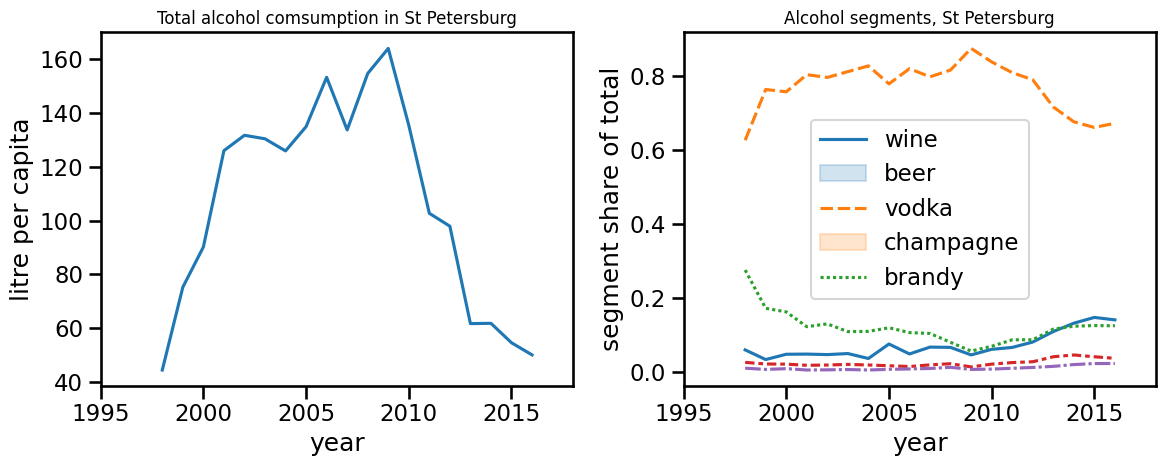

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5), tight_layout=True)

#Ax1
sns.lineplot(data=st_pb['total_alc'], ax=ax1)
ax1.set_title('Total alcohol comsumption in St Petersburg', fontsize=12)
ax1.set(
    xlabel = 'year', 
    ylabel = 'litre per capita',
    xlim = (1995, 2018)
)

#Ax2
sns.lineplot(data=st_pb[segments_shr], ax=ax2)
ax2.set_title('Alcohol segments, St Petersburg', fontsize=12)
ax2.set(
    xlabel = 'year',
    ylabel = 'segment share of total',
    xlim = (1995, 2018)
)
ax2.legend(['wine', 'beer', 'vodka', 'champagne', 'brandy'])
plt.show()

Conclusions: <br>

- Overall alcohol consumtion peaked in 2010 and steadily declined after dropping back to pre 2000 times.
- Vodka represents the highest share of all segments ex expected.
- Wine share of alcohol consumption has been steadily growing likely due to increasing income across different strata.

### Alcohol consumption trends in St. Petersburg vs National averages.

In [ ]:
segs = segments + ["total_alc"]

subset = pd.DataFrame()


def seg_series(reg='nat',s='total_alc'):
    """
    Returns a pandas series with national average or St Petersburg for a segment s.
    Arguments:
    reg: nat or sub
    s: segment to select (default: total alcohol)
    """
    if reg == "spb":
        subset = master[master["region"] == "Saint Petersburg"]
    else:
        subset = master
    
    if s == "total_alc":
        return subset.groupby(by='year')[s].mean()
    
    return subset.groupby(by='year')[s+'_shr'].mean() * 100 # Return a percentage value

for s in segs:
    # National Average
    subset["nat_" + s] = seg_series(s=s)
    
    # St Petersburg
    subset['spb_' + s] = seg_series(reg='spb', s=s)
    
labels = ["national","St Petersburg"]
